# Collaborative Filtering

## Importación de librerías

In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.3.0+cu121
12.1


In [2]:
# Reinstala PyTorch 2.3.0 con CUDA 12.1 (estable en Colab)
!pip install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Instala PyG y extensiones con soporte oficial
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install -q torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

  Preparing metadata (setup.py) ... done


In [4]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torch import nn, optim, Tensor
from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing


## Carga de datos

### Definición de funciones

Comenzamos definiendo las funciones necesarias para construir los nodos y las aristas del grafo a partir de los datos de usuarios, libros e interacciones.

In [5]:
# Cargar nodos de usuarios y libros
def load_node_csv(path, index_col):
    """
    Carga un CSV que contiene información sobre los nodos.

    Args:
        path (str): Ruta al archivo CSV.
        index_col (str): Nombre de la columna que se usará como índice.

    Returns:
        dict: Diccionario que mapea los valores del índice del CSV a IDs de nodo.
    """
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping

# Cargar aristas entre usuarios y libros
def load_edge_csv(df, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """
    Carga aristas entre usuarios e ítems (por ejemplo, libros) a partir de un DataFrame.

    Args:
        df (DataFrame): DataFrame que contiene las interacciones usuario-ítem.
        src_index_col (str): Nombre de la columna con los IDs de usuario.
        src_mapping (dict): Diccionario que mapea los IDs de usuario a índices de nodo.
        dst_index_col (str): Nombre de la columna con los IDs de ítems.
        dst_mapping (dict): Diccionario que mapea los IDs de ítems a índices de nodo.
        link_index_col (str): Nombre de la columna que contiene la interacción (por ejemplo, rating).
        rating_threshold (int, opcional): Umbral mínimo para considerar una interacción como positiva. Por defecto es 4.

    Returns:
        torch.Tensor: Matriz 2xN que contiene los pares de nodos conectados por N aristas.
    """
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)

Implementamos una función que realiza muestreo estructurado negativo para generar mini-batches compuestos por usuarios, ítems positivos e ítems negativos, necesarios para entrenar el modelo basado en grafos.

In [6]:
# Función que selecciona aleatoriamente un mini-lote de muestras positivas y negativas
def sample_mini_batch(batch_size, edge_index):
    """
    Selecciona aleatoriamente los índices de un mini-lote dado un grafo de adyacencia.

    Args:
        batch_size (int): tamaño del mini-lote
        edge_index (torch.Tensor): matriz 2 x N con los bordes del grafo

    Returns:
        tuple: índices de usuarios, índices de ítems positivos, índices de ítems negativos
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

### Cargamos y filtramos los datos

In [7]:
user_id_path = '/content/user_id_map.csv'
book_id_path = '/content/book_id_map.csv'
interactions_path = '/content/interactions_filtered.csv'
books_path = '/content/books_authors_genres.csv'

In [8]:
interactions = pd.read_csv(interactions_path)
books = pd.read_csv(books_path)

Aplicamos un filtrado para eliminar ítems con pocas interacciones y usuarios poco activos, mejorando así la calidad del grafo de interacciones. Esto reduce la dispersión y mejora el aprendizaje del modelo.

In [9]:
item_inter_counts = interactions.groupby("book_id").size()
popular_books = item_inter_counts[item_inter_counts >= 10].index
interactions = interactions[interactions["book_id"].isin(popular_books)]

user_inter_counts = interactions.groupby('user_id').size()
active_users = user_inter_counts[user_inter_counts >= 4].index
interactions = interactions[interactions['user_id'].isin(active_users)]

print(f"Interactions filtrado: {interactions.shape}")

num_users = interactions['user_id'].nunique()
num_items = interactions['book_id'].nunique()
print(f"{num_users=}, {num_items=}")

Interactions filtrado: (16803, 5)
num_users=3310, num_items=947


Aplicamos las funciones para crear los nodos y las aristas.

In [10]:
user_mapping = load_node_csv(user_id_path, index_col='user_id_csv')
book_mapping = load_node_csv(book_id_path, index_col='book_id_csv')

In [11]:
edge_index = load_edge_csv(
    interactions,
    src_index_col='user_id',
    src_mapping=user_mapping,
    dst_index_col='book_id',
    dst_mapping=book_mapping,
    link_index_col='rating',
    rating_threshold=4
)

# Verifica la forma de edge_index
print("edge_index:", edge_index)
print("edge_index.shape:", edge_index.shape)

edge_index: tensor([[    14,     14,     14,  ..., 873215, 873215, 873215],
        [ 11831,  10943,  10570,  ...,  39638,  39637,  39640]])
edge_index.shape: torch.Size([2, 16803])


Dividimos las interacciones del grafo entre usuarios y libros en tres subconjuntos: entrenamiento, validación y prueba, siguiendo una proporción del 80%, 10% y 10% respectivamente.

In [12]:
# Dividir los bordes del grafo en un 80/10/10 para entrenamiento, validación y prueba
num_users, num_books = len(user_mapping), len(book_mapping)
num_interacciones = edge_index.shape[1]
todos_los_indices = [i for i in range(num_interacciones)]

# 80% entrenamiento, 10% validación y 10% prueba
train_indices, test_indices = train_test_split(todos_los_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [13]:
print("train_edge_index.shape:", train_edge_index.shape)
print("val_edge_index.shape:", val_edge_index.shape)
print("test_edge_index.shape:", test_edge_index.shape)

train_edge_index.shape: torch.Size([2, 13442])
val_edge_index.shape: torch.Size([2, 1680])
test_edge_index.shape: torch.Size([2, 1681])


Convertimos los índices de los bordes del grafo en tensores dispersos (SparseTensor) para optimizar el almacenamiento y las operaciones sobre grafos grandes.

In [14]:
train_sparse_edge_index = SparseTensor(
    row=train_edge_index[0],
    col=train_edge_index[1],
    sparse_sizes=(num_users + num_books, num_users + num_books)
)

val_sparse_edge_index = SparseTensor(
    row=val_edge_index[0],
    col=val_edge_index[1],
    sparse_sizes=(num_users + num_books, num_users + num_books)
)

test_sparse_edge_index = SparseTensor(
    row=test_edge_index[0],
    col=test_edge_index[1],
    sparse_sizes=(num_users + num_books, num_users + num_books)
)

## Implementación de LightGCN

### Definición del modelo

A continuación, definimos el modelo LightGCN (Light Graph Convolutional Network), una red neuronal propuesta en el artículo LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation.

Este modelo está diseñado específicamente para sistemas de recomendación, eliminando componentes innecesarios como funciones de activación o capas de proyección, y enfocándose únicamente en la agregación de embeddings a lo largo de un grafo bipartito de usuarios e ítems.

La idea principal es realizar una propagación de mensajes ligera a través del grafo para capturar la estructura de las interacciones.
El modelo inicializa embeddings para usuarios e ítems, y luego los actualiza mediante varias capas de propagación sobre la matriz de adyacencia normalizada. Finalmente, se promedia la información agregada en cada capa para obtener una representación final que captura diferentes niveles de conectividad.

In [15]:
# Definimos el modelo LightGCN
class LightGCN(MessagePassing):
    """
    Modelo LightGCN propuesto en https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=16, K=2, add_self_loops=False):
        """
        Inicializa el modelo LightGCN.

        Args:
            num_users (int): Número de usuarios
            num_items (int): Número de ítems (libros)
            embedding_dim (int, opcional): Dimensión de los embeddings. Por defecto 16.
            K (int, opcional): Número de capas de propagación de mensajes. Por defecto 2.
            add_self_loops (bool, opcional): Si se añaden bucles propios en la propagación. Por defecto False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        # Embeddings iniciales de usuarios e ítems: e_u^0 y e_i^0
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)

        # Inicializamos los embeddings de usuarios e ítems con una distribución normal
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """
        Propagación hacia adelante del modelo LightGCN.

        Args:
            edge_index (SparseTensor): Matriz de adyacencia

        Returns:
            tuple (Tensor): Embeddings finales y originales de usuarios e ítems (e_u^K, e_u^0, e_i^K, e_i^0)
        """
        # Calculamos \tilde{A}: matriz de adyacencia normalizada simétricamente
        edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops)

        # Embedding inicial conjunto E^0 (usuarios + ítems)
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0]
        emb_k = emb_0

        # Propagación por K capas
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        # Promedio de los embeddings generados en cada capa (E^K)
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)

        # Separamos e_u^K y e_i^K (representaciones finales de usuarios e ítems)
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])

        # Devolvemos embeddings finales y los embeddings originales (iniciales)
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        """Devuelve los mensajes recibidos de los nodos vecinos."""
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        """Multiplica la matriz de adyacencia normalizada con los embeddings."""
        return matmul(adj_t, x)

# Instanciamos el modelo
model = LightGCN(num_users, num_books)

### Función de pérdida

Utilizamos la pérdida `Bayesian Personalized Ranking (BPR)`, una función de tipo comparativa por pares que favorece que, para cada usuario, las predicciones asociadas a ejemplos positivos sean más altas que las de los ejemplos negativos.

In [16]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """
    Función de pérdida Bayesian Personalized Ranking, descrita en https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): e_i_k de los ítems positivos
        pos_items_emb_0 (torch.Tensor): e_i_0 de los ítems positivos
        neg_items_emb_final (torch.Tensor): e_i_k de los ítems negativos
        neg_items_emb_0 (torch.Tensor): e_i_0 de los ítems negativos
        lambda_val (float): valor lambda para el término de regularización

    Returns:
        torch.Tensor: valor escalar de la pérdida BPR
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2))  # Pérdida L2

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1)  # Puntuaciones predichas de los ejemplos positivos
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1)  # Puntuaciones predichas de los ejemplos negativos

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

### Métricas de evaluación

Para evaluar la el sistema de recomendación, empleamos métricas estándar centradas en las primeras posiciones del ranking generado para cada usuario. Concretamente, utilizamos `precisión@20`, `recall@20` y `nDCG@20`, que nos permiten medir tanto la relevancia como la ordenación de los ítems recomendados. Estas métricas se enfocan en los 20 primeros elementos recomendados.

In [17]:
# Función auxiliar para obtener N_u (ítems positivos por usuario)
def get_user_positive_items(edge_index):
    """
    Genera un diccionario con los ítems positivos para cada usuario

    Args:
        edge_index (torch.Tensor): lista de aristas de tamaño 2 por N

    Returns:
        dict: diccionario con los ítems positivos de cada usuario
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [18]:
# Calcula recall@K y precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """
    Calcula recall @ k y precision @ k

    Args:
        groundTruth (list): lista de listas con los ítems altamente valorados por cada usuario
        r (list): lista de listas que indica si cada ítem recomendado en top k para cada usuario
            es un ítem relevante en el top k ground truth o no
        k (int): determina los primeros k ítems para calcular precision y recall

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # Número de ítems correctamente predichos por usuario
    # Número de ítems que cada usuario valoró positivamente en el conjunto de prueba
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [19]:
# Calcula NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """
    Calcula Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): lista de listas con los ítems altamente valorados por cada usuario
        r (list): lista de listas que indica si cada ítem recomendado en top k para cada usuario
            es un ítem relevante en el top k ground truth o no
        k (int): determina los primeros k ítems para calcular ndcg

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

Definimos la función que evalúa en batches las métricas recall, precisión y NDCG para evitar problemas de memoria, procesando recomendaciones para un conjunto de usuarios.

In [20]:
def get_metrics(model, edge_index, exclude_edge_indices, k, batch_size=512):
    """
    Calcula las métricas de evaluación en batches para evitar desbordamiento de memoria.

    Esta función evalúa el desempeño del modelo LightGCN calculando las métricas
    de recall, precisión y NDCG en el top-k ítems recomendados para cada usuario.
    Para manejar grandes conjuntos de datos, realiza el cálculo en lotes (batches)
    de usuarios, excluyendo ítems ya vistos en entrenamiento para evitar sesgos en la evaluación.

    Args:
        model (LightGCN): modelo LightGCN entrenado
        edge_index (torch.Tensor): lista 2 x N de aristas para el conjunto a evaluar
        exclude_edge_indices (list[torch.Tensor]): lista de aristas a excluir del ranking (por ejemplo, entrenamiento)
        k (int): número de ítems top-k para evaluar
        batch_size (int): número de usuarios por lote

    Returns:
        tuple: recall @ k, precisión @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight.detach()
    item_embedding = model.items_emb.weight.detach()

    num_users = user_embedding.shape[0]
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    recall_list = []
    precision_list = []
    ndcg_list = []

    for start in range(0, len(users), batch_size):
        end = min(start + batch_size, len(users))
        batch_users = users[start:end]

        batch_user_emb = user_embedding[batch_users]  # (batch, emb_size)
        rating = torch.matmul(batch_user_emb, item_embedding.T)  # (batch, num_items)

        # Excluir ítems vistos en entrenamiento de la recomendación
        for exclude_edge_index in exclude_edge_indices:
            user_pos_items = get_user_positive_items(exclude_edge_index)
            for i, user in enumerate(batch_users):
                uid = user.item()
                if uid in user_pos_items:
                    rating[i, user_pos_items[uid]] = -(1 << 10)  # Excluir

        _, top_K_items = torch.topk(rating, k=k)  # (batch, k)

        r = []
        for i, user in enumerate(batch_users):
            uid = user.item()
            ground_truth_items = test_user_pos_items[uid]
            label = [item in ground_truth_items for item in top_K_items[i]]
            r.append(label)

        r = torch.tensor(np.array(r).astype('float'))

        # Calcular métricas para el batch
        batch_ground_truth = [test_user_pos_items[user.item()] for user in batch_users]
        batch_recall, batch_precision = RecallPrecision_ATk(batch_ground_truth, r, k)
        batch_ndcg = NDCGatK_r(batch_ground_truth, r, k)

        recall_list.append(batch_recall)
        precision_list.append(batch_precision)
        ndcg_list.append(batch_ndcg)

    # Promedio de métricas entre batches
    recall = sum(recall_list) / len(recall_list)
    precision = sum(precision_list) / len(precision_list)
    ndcg = sum(ndcg_list) / len(ndcg_list)

    return recall, precision, ndcg

Definimos la función que realiza la evaluación completa del modelo, calculando la pérdida BPR y las métricas recall, precisión y NDCG sobre el conjunto de evaluación.

In [21]:
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """
    Evalúa la pérdida del modelo y las métricas incluyendo recall, precisión y ndcg @ k

    Args:
        model (LightGCN): modelo LightGCN
        edge_index (torch.Tensor): lista 2 x N de aristas para el conjunto a evaluar
        sparse_edge_index (sparseTensor): matriz de adyacencia dispersa para el conjunto a evaluar
        exclude_edge_indices ([tipo]): lista 2 x N de aristas para excluir de la evaluación
        k (int): determina el top k de ítems para calcular las métricas
        lambda_val (float): valor lambda para la pérdida BPR

    Returns:
        tuple: pérdida BPR, recall @ k, precisión @ k, ndcg @ k
    """
    # Obtener embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(sparse_edge_index)

    edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(model, edge_index, exclude_edge_indices, k, batch_size = 128)

    return loss, recall, precision, ndcg

## Entrenamiento

Definimos las variables para los parámetros clave para el entrenamiento y evaluación del modelo.

In [22]:
ITERATIONS = 20000
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

# Hiperparámetros optimizados de CF
BATCH_SIZE = 1024
LR = 1e-3
LAYERS = 2
EMBEDDING_DIM = 32

Realizamos la configuración inicial para el entrenamiento.

In [23]:
# Configura el dispositivo: usa GPU si está disponible, sino CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

# Mueve el modelo al dispositivo y lo pone en modo entrenamiento.
model = model.to(device)
model.train()

# Configura el optimizador Adam con tasa de aprendizaje definida.
optimizer = optim.Adam(model.parameters(), lr=LR)

# Reducción de la tasa de aprendizaje de forma exponencial durante el entrenamiento.
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Mueve los índices de aristas al dispositivo para entrenamiento y validación.
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)
val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


Llevamos a cabo el entrenamiento del modelo, donde en cada iteración se calcula la pérdida con mini batches, se actualizan los parámetros, y periódicamente se evalúa el rendimiento en el conjunto de validación.

In [24]:
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # Propagación
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

    # Mini batches
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # Cálculo de la pérdida
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if (iter+1) % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteración {iter+1}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if (iter+1) % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteración 200/20000] train_loss: -0.69595, val_loss: -0.69268, val_recall@20: 0.00178, val_precision@20: 0.00011, val_ndcg@20: 0.00099
[Iteración 400/20000] train_loss: -0.70814, val_loss: -0.69779, val_recall@20: 0.17772, val_precision@20: 0.0112, val_ndcg@20: 0.12491
[Iteración 600/20000] train_loss: -0.74501, val_loss: -0.71682, val_recall@20: 0.32276, val_precision@20: 0.02033, val_ndcg@20: 0.20263
[Iteración 800/20000] train_loss: -0.82467, val_loss: -0.75928, val_recall@20: 0.39314, val_precision@20: 0.02467, val_ndcg@20: 0.24151
[Iteración 1000/20000] train_loss: -0.9398, val_loss: -0.83137, val_recall@20: 0.42714, val_precision@20: 0.02664, val_ndcg@20: 0.26129
[Iteración 1200/20000] train_loss: -1.07662, val_loss: -0.93219, val_recall@20: 0.44367, val_precision@20: 0.02776, val_ndcg@20: 0.27287
[Iteración 1400/20000] train_loss: -1.30002, val_loss: -1.06081, val_recall@20: 0.4537, val_precision@20: 0.02838, val_ndcg@20: 0.28064
[Iteración 1600/20000] train_loss: -1.56504, val

Generamos una gráfica que muestra la evolución de la pérdida durante el entrenamiento y la validación a lo largo de las iteraciones.

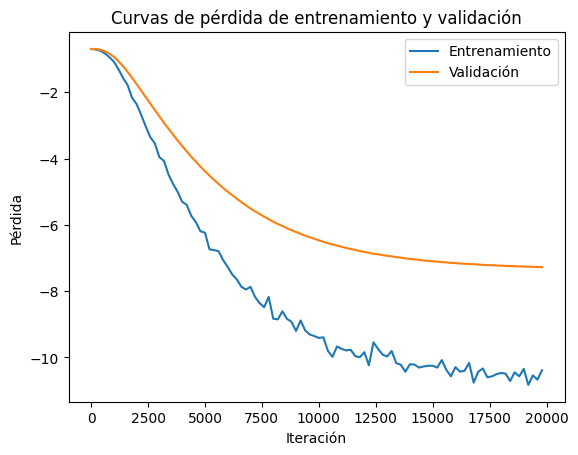

In [25]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='Entrenamiento')
plt.plot(iters, val_losses, label='Validación')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.title('Curvas de pérdida de entrenamiento y validación')
plt.legend()
plt.show()

Evaluamos el modelo final en el conjunto de prueba y mostramos las métricas obtenidas.

In [ ]:
model.eval()

with torch.no_grad():
    users_emb_final, _, items_emb_final, _ = model(train_sparse_edge_index)

# Guardar los embeddings finales de usuarios e ítems
torch.save({
    'users_emb_final_CF': users_emb_final.cpu(),
    'items_emb_final_CF': items_emb_final.cpu()
}, 'lightgcn_CF_embeddings.pt')

test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}]")

[test_loss: -7.46156, test_recall@20: 0.50208, test_precision@20: 0.03119, test_ndcg@20: 0.31935]


In [ ]:
# Guardar el modelo entrenado

torch.save(model.state_dict(), 'lightgcn_CF_model.pth')

## Ejemplo de recomendaciones para usuarios

In [28]:
# Modo evaluación (desactiva dropout, etc.)
model.eval()

# Cargamos el dataset de libros y creamos diccionarios para los títulos y géneros
df = pd.read_csv(books_path)
bookid_title = pd.Series(df.title.values, index=df.book_id).to_dict()
bookid_genres = pd.Series(df.genres.values, index=df.book_id).to_dict()

# Obtenemos los ítems con los que cada usuario ha interactuado positivamente
user_pos_items = get_user_positive_items(edge_index)

Definimos una función que genera y muestra recomendaciones personalizadas para un usuario. Incluye libros que ya le gustaron, según sus interacciones pasadas, y sugerencias nuevas que aún no ha visto.

In [29]:
def make_predictions(user_id, num_recs):
    # Obtenemos el índice interno y el embedding del usuario
    user_idx = user_mapping[user_id]
    e_u = model.users_emb.weight[user_idx]

    # Similitud entre el usuario y todos los ítems (productos/libros)
    scores = model.items_emb.weight @ e_u

    # Scores ordenados de mayor a menor
    values, indices = torch.topk(scores, k=scores.size(0))

    # IDs de libros ordenados según la predicción
    index_to_book_id = {v: k for k, v in book_mapping.items()}
    ranked_book_ids = [index_to_book_id[i.item()] for i in indices if i.item() in index_to_book_id]

    # Libros que le gustan al usuario
    seen_books = [book for book in ranked_book_ids if book in user_pos_items[user_id]][:num_recs]
    print(f"Libros que el usuario {user_id} ha valorado positivamente:")
    for book_id in seen_books:
        title = bookid_title.get(book_id, "Título desconocido")
        genre = bookid_genres.get(book_id, "Género desconocido")
        print(f"Título: {title}, Géneros: {genre}")

    # Libros recomendados para el usuario
    unseen_books = [book for book in ranked_book_ids if book not in user_pos_items[user_id]][:num_recs]
    print(f"\nRecomendaciones de libros para el usuario {user_id}:")
    for book_id in unseen_books:
        title = bookid_title.get(book_id, "Título desconocido")
        genre = bookid_genres.get(book_id, "Género desconocido")
        print(f"Título: {title}, Géneros: {genre}")

Probamos nuestra función en un usuario aleatorio.

In [30]:
random_user_id = random.choice(list(interactions.user_id))
print(f"Usuario aleatorio: {random_user_id}")

make_predictions(random_user_id, num_recs=10)

Usuario aleatorio: 201041
Libros que el usuario 201041 ha valorado positivamente:
Título: Fighting Ruben Wolfe (Wolfe Brothers, #2), Géneros: ['young-adult', 'fiction', 'children']
Título: 13 Little Blue Envelopes (Little Blue Envelope, #1), Géneros: ['young-adult', 'romance', 'fiction', 'mystery, thriller, crime']
Título: Underdog (Wolfe Brothers, #1), Géneros: ['young-adult', 'fiction', 'children']
Título: Define Normal, Géneros: ['young-adult', 'fiction', 'romance', 'children']
Título: Rainbow Boys (Rainbow Trilogy, #1), Géneros: ['young-adult', 'fiction', 'romance']
Título: Surviving Antarctica: Reality TV 2083, Géneros: ['young-adult', 'fiction', 'fantasy, paranormal', 'children']

Recomendaciones de libros para el usuario 201041:
Título: Devilish, Géneros: ['young-adult', 'fantasy, paranormal', 'fiction', 'romance', 'mystery, thriller, crime']
Título: Whale Talk, Géneros: ['young-adult', 'fiction']
Título: Blue Noon (Midnighters, #3), Géneros: ['young-adult', 'fantasy, paranormal

Probamos con otro usuario.

In [31]:
USER_ID = 14
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Libros que el usuario 14 ha valorado positivamente:
Título: King Dork (King Dork, #1), Géneros: ['young-adult', 'fiction', 'mystery, thriller, crime', 'romance', 'children']
Título: Trials of Death (Cirque Du Freak, #5), Géneros: ['fantasy, paranormal', 'young-adult', 'fiction', 'mystery, thriller, crime', 'children']
Título: Vampire Mountain (Cirque Du Freak, #4), Géneros: ['fantasy, paranormal', 'young-adult', 'fiction', 'children', 'mystery, thriller, crime']
Título: Absolutely Mahvelous, Géneros: ['history, historical fiction, biography', 'young-adult']
Título: Dicey's Song (Tillerman Cycle, #2), Géneros: ['young-adult', 'fiction', 'children', 'history, historical fiction, biography']

Recomendaciones de libros para el usuario 14:
Título: The Lake of Souls, Géneros: ['fantasy, paranormal', 'young-adult', 'fiction', 'children', 'mystery, thriller, crime']
Título: Cuba 15, Géneros: ['young-adult', 'fiction', 'romance']
Título: The Red Dice (The Last Vampire #3), Géneros: ['young-adul